# Test model

## Import libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import PIL
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import models
from utilities import ChestXrayHDF5

## Select dataset and best models

In [2]:
dataset = ChestXrayHDF5(f"/home/aisinai/work/HDF5_datasets/COVID19_binary_test_1024.hdf5")
model_scores = torch.load("/home/aisinai/work/covid19/densenet121/20200717/score3/best_densenet_348.pt")
model_admits = torch.load("/home/aisinai/work/covid19/densenet121/20200717/admit3/best_densenet_035.pt")

## Compute predictions

In [3]:
scores = []
admits = []
intubs = []
deaths = []
preds_scores = []
preds_admits = []

for i, (img, score, admit, intub, death) in enumerate(dataset):
    sample_img = torch.rand((1,3,1024,1024))
    sample_img[0,:] = img
    sample_img = sample_img.cuda()
    scores.append(score.numpy())
    admits.append(admit.numpy())
    intubs.append(intub.numpy())
    deaths.append(death.numpy())
    preds_scores.append(model_scores(sample_img).detach().cpu().numpy()[0])
    preds_admits.append(model_admits(sample_img).detach().cpu().numpy()[0])
    if (i + 1) == len(dataset):
        break

## Remove DNI from intubation predictions

In [4]:
intubs_no_DNI = intubs.copy()
preds_scores_no_DNI = preds_scores.copy()
preds_admits_no_DNI = preds_admits.copy()
for index in [124, 123, 100, 89, 64]:
    del intubs_no_DNI[index]
    del preds_scores_no_DNI[index]
    del preds_admits_no_DNI[index]

## Compue AUROC and generate graph

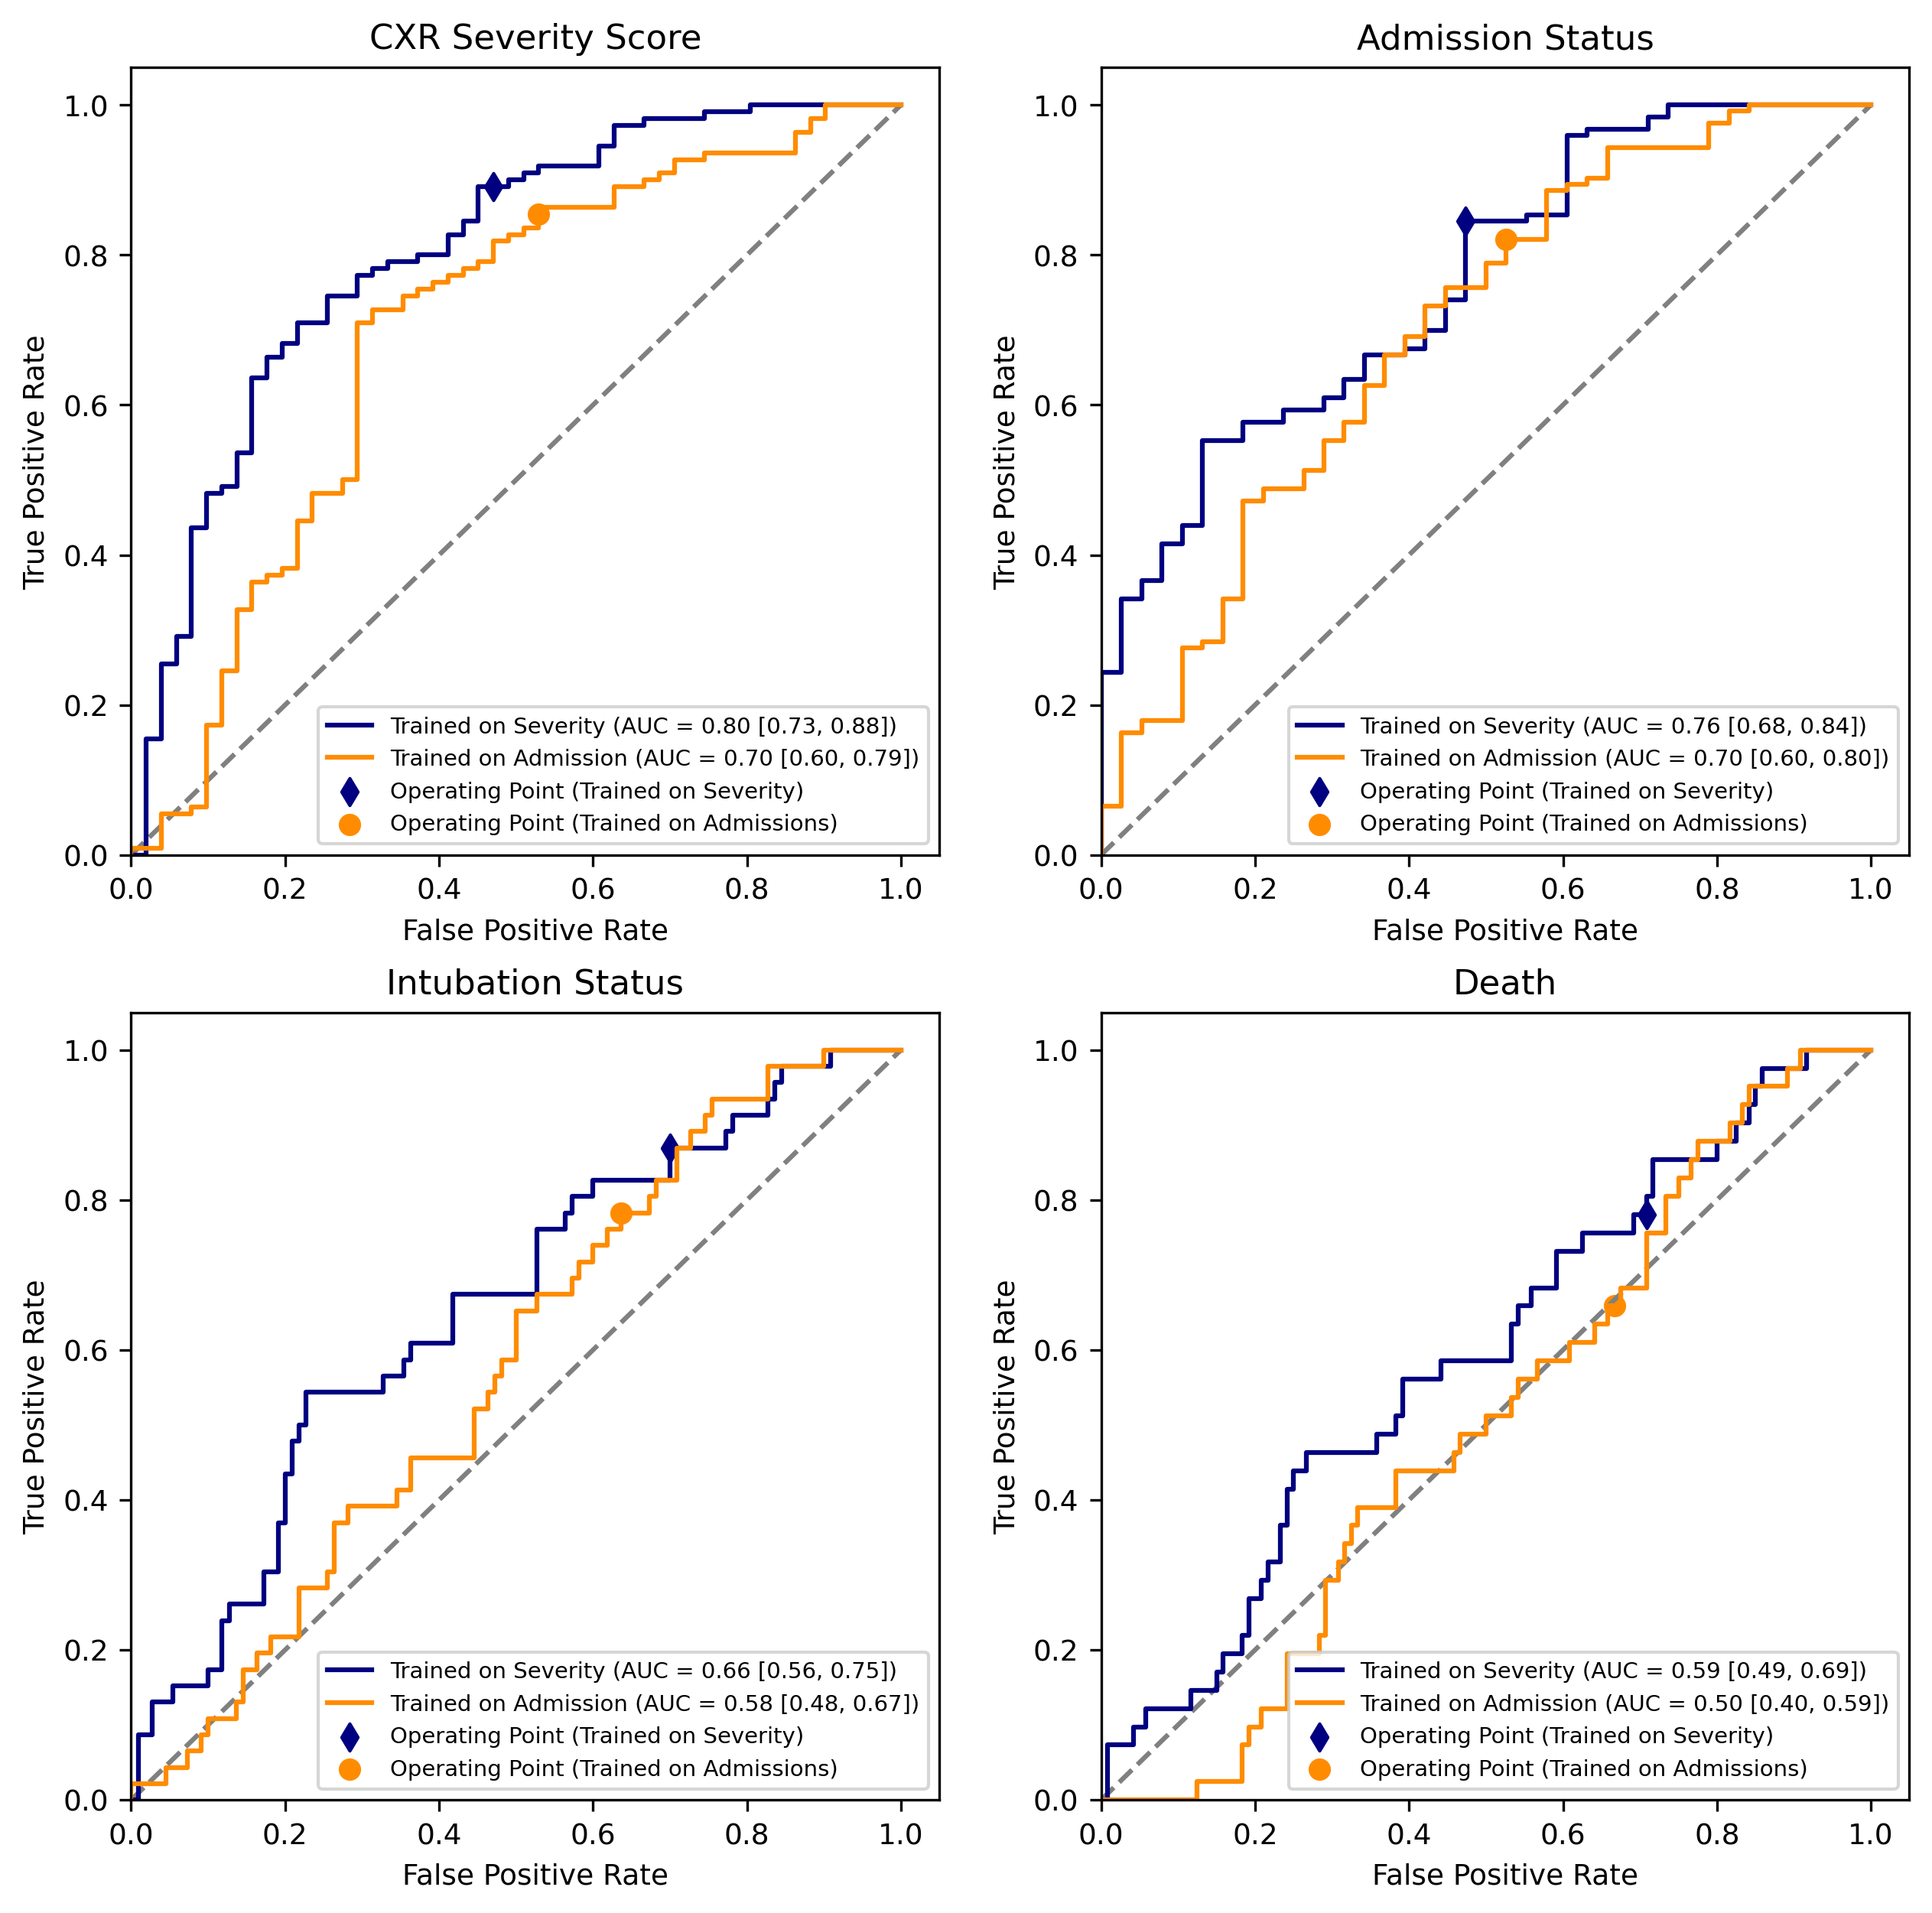

In [5]:
fontsize = 9
font = {'size': fontsize}
leg_fontsize = 7
plt.rc('font', **font)
dpi = 300
fig = plt.figure(figsize=(10, 10), dpi=dpi)

ymin = 0
ax1 = fig.add_subplot(221)

fpr_scores, tpr_scores, thresholds = roc_curve(scores, preds_scores)
roc_auc_scores = auc(fpr_scores, tpr_scores)
fpr_admits, tpr_admits, thresholds = roc_curve(scores, preds_admits)
roc_auc_admits = auc(fpr_admits, tpr_admits)

ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax1.plot(fpr_scores, tpr_scores, color='navy',
         label=f'Trained on Severity (AUC = {roc_auc_scores:.2f} [0.73, 0.88])')
ax1.scatter(0.4705, 0.8909, color='navy', marker='d',
         label=f'Operating Point (Trained on Severity)')
ax1.plot(fpr_admits, tpr_admits, color='darkorange',
         label=f'Trained on Admission (AUC = {roc_auc_admits:.2f} [0.60, 0.79])')
ax1.scatter(0.5294, 0.8545, color='darkorange', marker='o',
         label=f'Operating Point (Trained on Admissions)')
ax1.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('CXR Severity Score')
ax1.legend(loc="lower right", fontsize = leg_fontsize)

ax2 = fig.add_subplot(222)

fpr_scores, tpr_scores, thresholds = roc_curve(admits, preds_scores)
roc_auc_scores = auc(fpr_scores, tpr_scores)
fpr_admits, tpr_admits, thresholds = roc_curve(admits, preds_admits)
roc_auc_admits = auc(fpr_admits, tpr_admits)

ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax2.plot(fpr_scores, tpr_scores, color='navy',
         label=f'Trained on Severity (AUC = {roc_auc_scores:.2f} [0.68, 0.84])')
ax2.scatter(0.4737, 0.8455, color='navy', marker='d',
         label=f'Operating Point (Trained on Severity)')
ax2.plot(fpr_admits, tpr_admits, color='darkorange',
         label=f'Trained on Admission (AUC = {roc_auc_admits:.2f} [0.60, 0.80])')
ax2.scatter(0.5263, 0.8211, color='darkorange', marker='o',
         label=f'Operating Point (Trained on Admissions)')
ax2.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Admission Status')
ax2.legend(loc="lower right", fontsize = leg_fontsize)

ax3 = fig.add_subplot(223)

fpr_scores, tpr_scores, thresholds = roc_curve(intubs_no_DNI, preds_scores_no_DNI)
roc_auc_scores = auc(fpr_scores, tpr_scores)
fpr_admits, tpr_admits, thresholds = roc_curve(intubs_no_DNI, preds_admits_no_DNI)
roc_auc_admits = auc(fpr_admits, tpr_admits)

ax3.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax3.plot(fpr_scores, tpr_scores, color='navy',
         label=f'Trained on Severity (AUC = {roc_auc_scores:.2f} [0.56, 0.75])')
ax3.scatter(0.7, 0.8696, color='navy', marker='d',
         label=f'Operating Point (Trained on Severity)')
ax3.plot(fpr_admits, tpr_admits, color='darkorange',
         label=f'Trained on Admission (AUC = {roc_auc_admits:.2f} [0.48, 0.67])')
ax3.scatter(0.6364, 0.7826, color='darkorange', marker='o',
         label=f'Operating Point (Trained on Admissions)')
ax3.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('Intubation Status')
ax3.legend(loc="lower right", fontsize = leg_fontsize)

graph_intub_x = fpr_scores
graph_intub_y = tpr_scores

ax4 = fig.add_subplot(224)

fpr_scores, tpr_scores, thresholds = roc_curve(deaths, preds_scores)
roc_auc_scores = auc(fpr_scores, tpr_scores)
fpr_admits, tpr_admits, thresholds = roc_curve(deaths, preds_admits)
roc_auc_admits = auc(fpr_admits, tpr_admits)

ax4.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax4.plot(fpr_scores, tpr_scores, color='navy',
         label=f'Trained on Severity (AUC = {roc_auc_scores:.2f} [0.49, 0.69])')
ax4.scatter(0.7083, 0.7805, color='navy', marker='d',
         label=f'Operating Point (Trained on Severity)')
ax4.plot(fpr_admits, tpr_admits, color='darkorange',
         label=f'Trained on Admission (AUC = {roc_auc_admits:.2f} [0.40, 0.59])')
ax4.scatter(0.6667, 0.6585, color='darkorange', marker='o',
         label=f'Operating Point (Trained on Admissions)')
ax4.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('Death')
ax4.legend(loc="lower right", fontsize = leg_fontsize)

graph_death_x = fpr_scores
graph_death_y = tpr_scores
fig.show()
fig.savefig('Figure 3.tif')

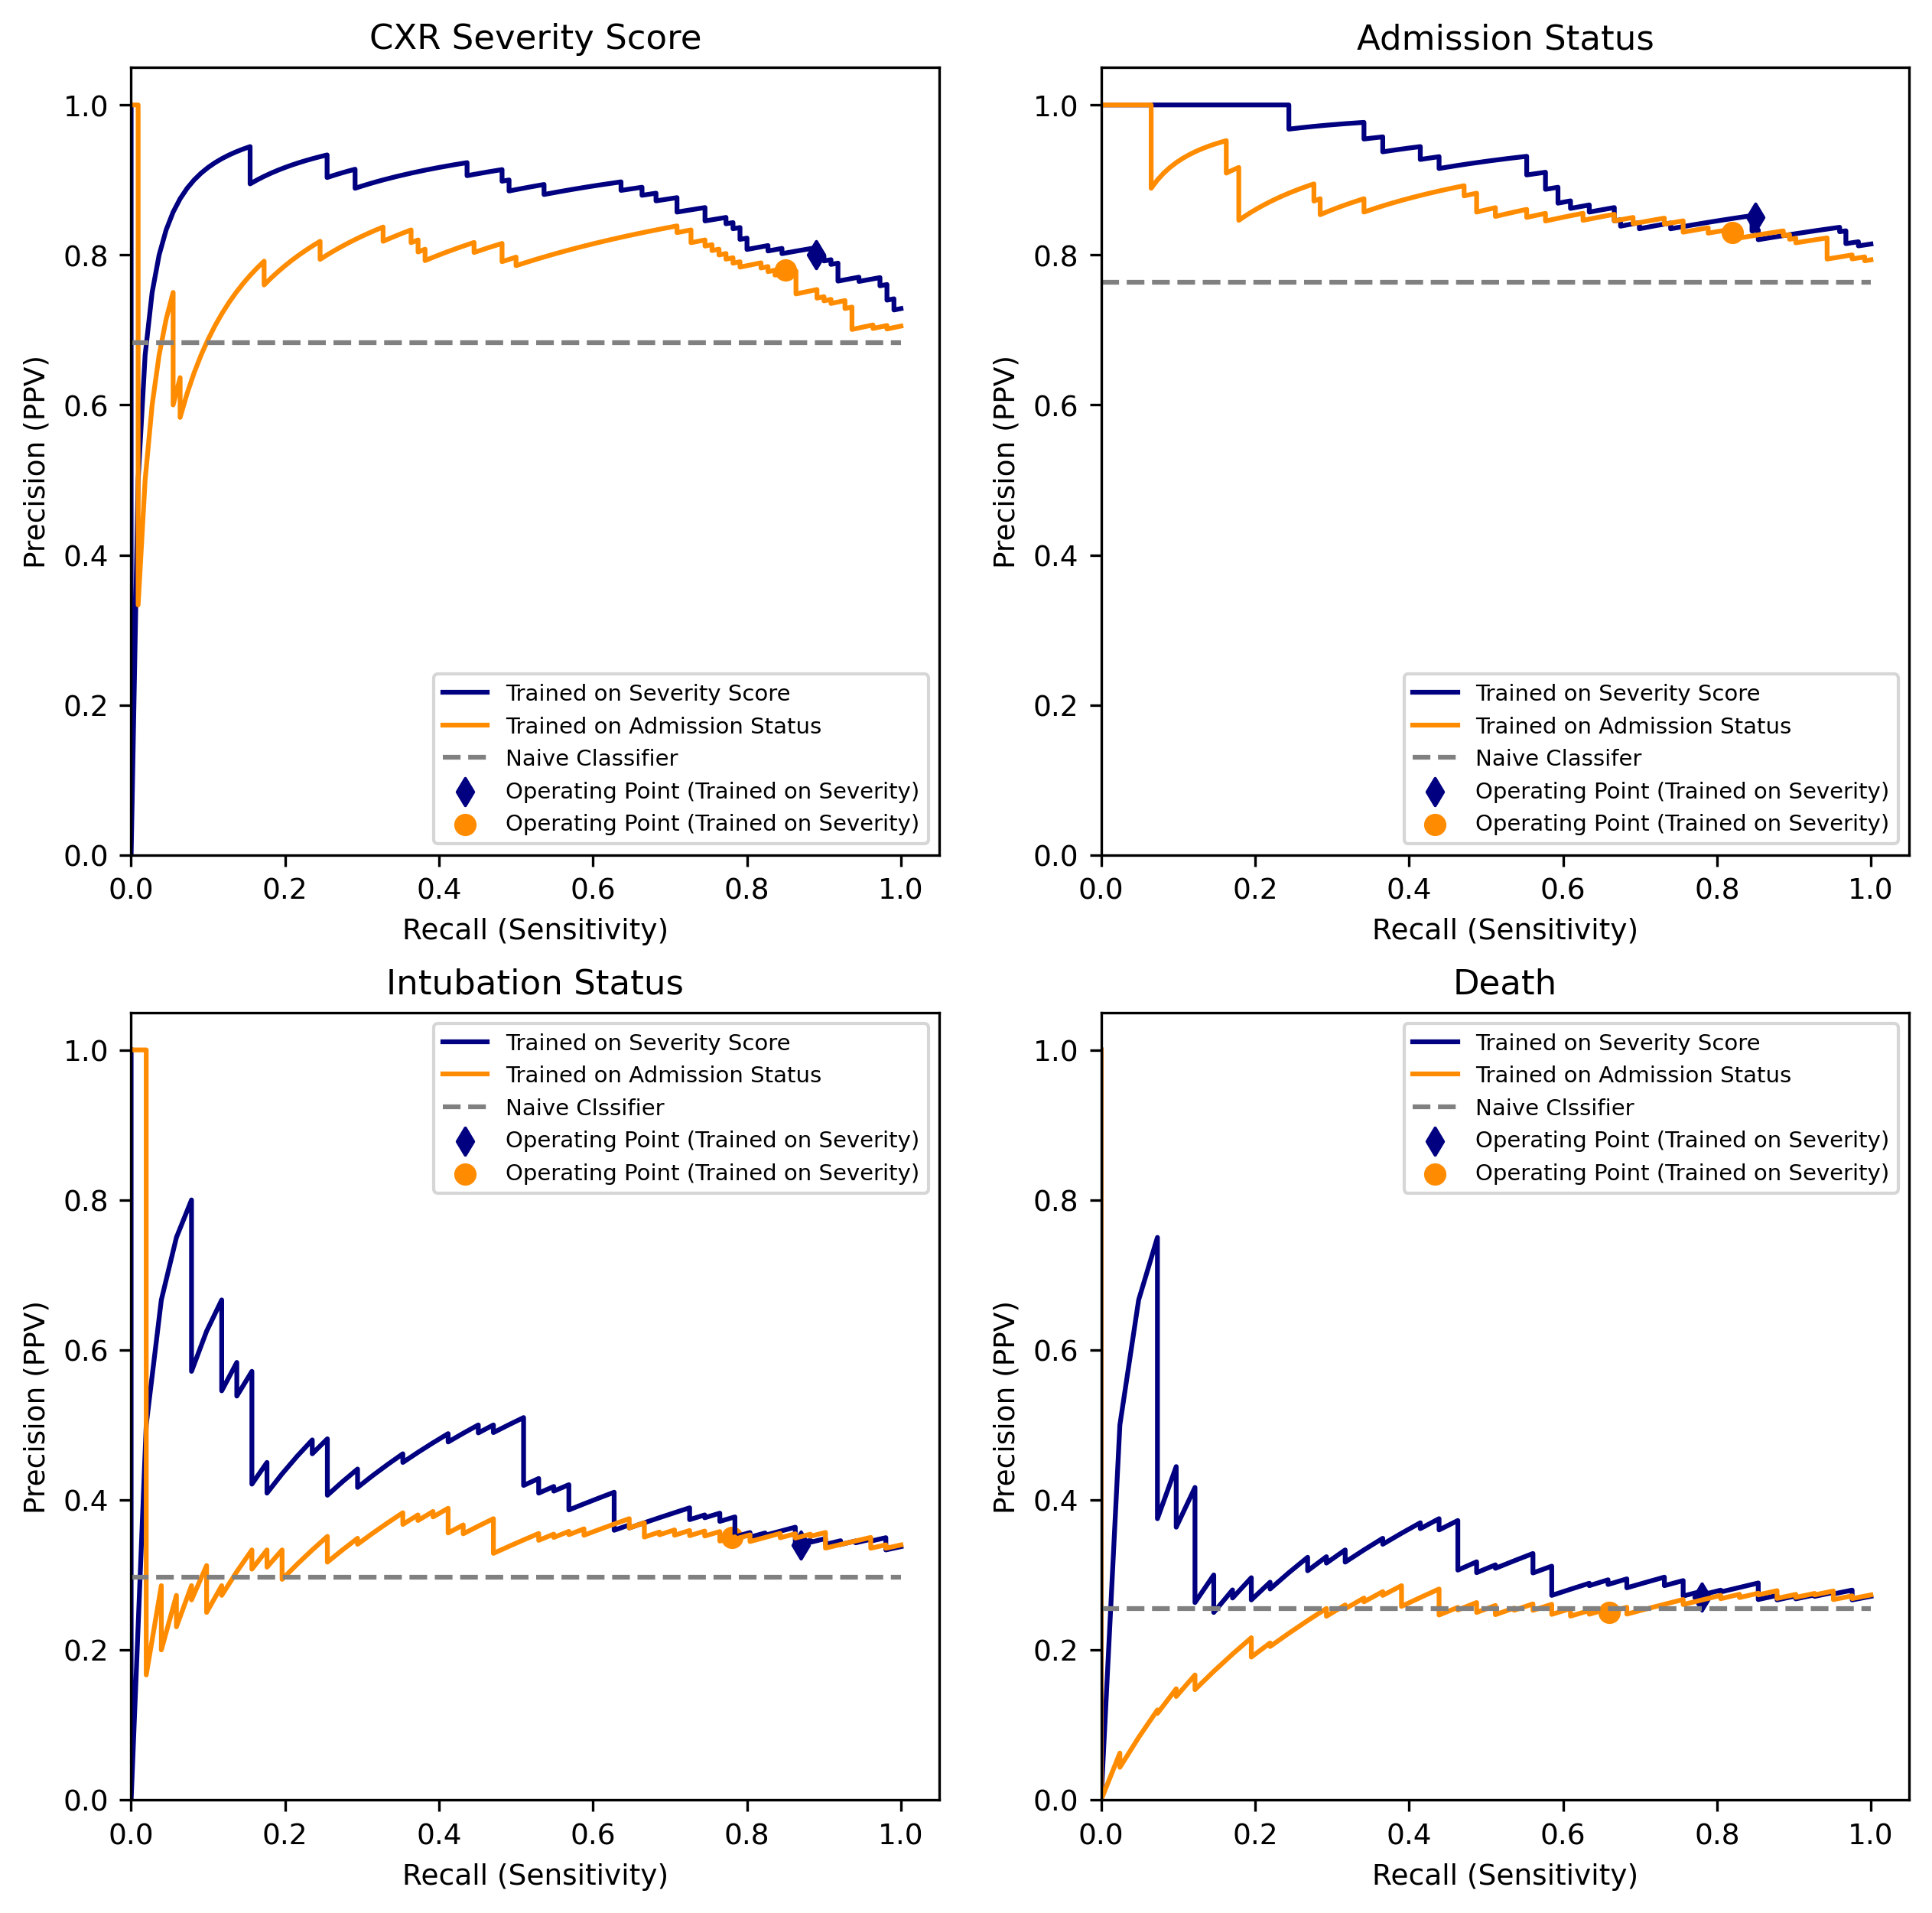

In [6]:
fig = plt.figure(figsize=(10, 10), dpi=dpi)

ymin = 0
ax1 = fig.add_subplot(221)

precision_scores, recall_scores, _ = precision_recall_curve(scores, preds_scores)
roc_auc_scores = auc(fpr_scores, tpr_scores)
precision_admits, recall_admits, _ = precision_recall_curve(scores, preds_admits)
roc_auc_admits = auc(fpr_scores, tpr_scores)

ax1.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax1.scatter(0.89, 0.80, color='navy', marker='d',
         label=f'Operating Point (Trained on Severity)')
ax1.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax1.scatter(0.85, 0.78, color='darkorange', marker='o',
         label=f'Operating Point (Trained on Severity)')
ax1.plot([0, 1], [110/161, 110/161], color='gray', linestyle='--',
         label='Naive Classifier')
ax1.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax1.set_xlabel('Recall (Sensitivity)')
ax1.set_ylabel('Precision (PPV)')
ax1.set_title('CXR Severity Score')
ax1.legend(loc="lower right", fontsize=leg_fontsize)

ax2 = fig.add_subplot(222)

precision_scores, recall_scores, _ = precision_recall_curve(admits, preds_scores)
precision_admits, recall_admits, _ = precision_recall_curve(admits, preds_admits)

ax2.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax2.scatter(0.85, 0.85, color='navy', marker='d',
         label=f'Operating Point (Trained on Severity)')
ax2.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax2.scatter(0.82, 0.83, color='darkorange', marker='o',
         label=f'Operating Point (Trained on Severity)')
ax2.plot([0, 1], [123/161, 123/161], color='gray', linestyle='--',
         label='Naive Classifer')
ax2.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax2.set_xlabel('Recall (Sensitivity)')
ax2.set_ylabel('Precision (PPV)')
ax2.set_title('Admission Status')
ax2.legend(loc="lower right", fontsize=leg_fontsize)

ax3 = fig.add_subplot(223)

precision_scores, recall_scores, _ = precision_recall_curve(intubs, preds_scores)
precision_admits, recall_admits, _ = precision_recall_curve(intubs, preds_admits)

ax3.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax3.scatter(0.87, 0.34, color='navy', marker='d',
         label=f'Operating Point (Trained on Severity)')
ax3.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax3.scatter(0.78, 0.35, color='darkorange', marker='o',
         label=f'Operating Point (Trained on Severity)')
ax3.plot([0, 1], [46/155, 46/155], color='gray', linestyle='--',
         label='Naive Clssifier')
ax3.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax3.set_xlabel('Recall (Sensitivity)')
ax3.set_ylabel('Precision (PPV)')
ax3.set_title('Intubation Status')
ax3.legend(loc="upper right", fontsize=leg_fontsize)

ax4 = fig.add_subplot(224)

precision_scores, recall_scores, _ = precision_recall_curve(deaths, preds_scores)
precision_admits, recall_admits, _ = precision_recall_curve(deaths, preds_admits)

ax4.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax4.scatter(0.78, 0.27, color='navy', marker='d',
         label=f'Operating Point (Trained on Severity)')
ax4.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax4.scatter(0.66, 0.25, color='darkorange', marker='o',
         label=f'Operating Point (Trained on Severity)')
ax4.plot([0, 1], [41/161, 41/161], color='gray', linestyle='--',
         label='Naive Clssifier')
ax4.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax4.set_xlabel('Recall (Sensitivity)')
ax4.set_ylabel('Precision (PPV)')
ax4.set_title('Death')
ax4.legend(loc="upper right", fontsize=leg_fontsize)
fig.show()
fig.savefig('Figure 4.tif')

## Plot EHR Data

In [19]:
ehr_pred=[0.130564491,0.07191964054,0.4108149318,0.4618216974,0.3987415772,0.08835952869,0.4905922636,0.4829371945,0.3723650367,0.3823459702,0.4817882463,0.09783619324,0.4044593484,0.3135126962,0.5404870662,0.46696287,0.3581849186,0.04576698761,0.4268603893,0.2404314886,0.2720448968,0.07017764975,0.9569039583,0.3683488844,0.3376907091,0.3207034306,0.3858600523,0.2562886488,0.4536248352,0.3111324228,0.5236197411,0.5266732671,0.5336700945,0.1181193392,0.2403509278,0.6168598672,0.3463854854,0.4558157846,0.1083548526,0.4187040517,0.9987029766,0.3184204568,0.4031212138,0.3576391209,0.5100032152,0.4748341025,0.2877174112,0.3820650315,0.32714354,0.2812867315,0.3190663902,0.4809061642,0.483486698,0.4227265342,0.4468230605,0.3572714507,0.3559556961,0.4302866707,0.5161880067,0.430581205,0.5162555091,0.9686889278,0.1663825234,0.3475680936,0.91515608,0.6577204623,0.4917028366,0.3624960544,0.3367533213,0.3395941302,0.8576780831,0.4925120576,0.6955088953,0.240155453,0.08692820027,0.8759282485,0.4967933766,0.8507292362,0.5934665488,0.4119341541,0.4263271154,0.3336742238,0.1025254023,0.4012158665,0.249520718,0.8283688509,0.5967337129,0.6481463279,0.1644067576,0.351234155,0.575098192,0.7884483857,0.3978429447,0.4906162755,0.7442420661,0.3500907524,0.7954160726,0.5159370694,0.7418142307,0.7082985987,0.2560417378,0.9709561695,0.736651309,0.9420442462,0.862929699,0.991354466,0.7866972887,0.934353553,0.8663320218,0.994681175,0.8118843529,0.8886457085,0.5161621571,0.4542066224,0.8689247225,0.7595223853,0.4671264331,0.8406619508,0.2908348575,0.4732330537,0.5347426705,0.770764024,0.436989194,0.7984046448,0.5233780259,0.9750514881,0.8400098115,0.9603933099,0.9224239621,0.9648292421,0.9663504282,0.6691512491,0.4770874576,0.6714581055,0.8606697494,0.9694008441,0.7528203492,0.8837316743,0.9605805483,0.747200196,0.334459335,0.1690753724,0.06580319113,0.762103422,0.9567771848,0.7376816074,0.948812032,0.8093337128,0.9681674184,0.7656043591,0.6340903982,0.8359304558,0.8238793246,0.9214966914,0.8105282793,0.3473057056]
cxr_ehr_pred=[0.08760381699,0.09307795489,0.3084236156,0.9513119482,0.421830048,0.1253615001,0.3210772789,0.3699976551,0.4059053891,0.2027733628,0.3967120399,0.1403704427,0.2658249507,0.3166397079,0.9137754683,0.3233724295,0.1652608327,0.07876886734,0.3724497849,0.2421812032,0.3430285883,0.07724546267,0.9240512537,0.262696403,0.1845384886,0.3223916123,0.4279001477,0.2957950967,0.1737460232,0.2717829083,0.9061618242,0.9840386493,0.9352682896,0.1126348267,0.230516127,0.6293481223,0.1906435328,0.410168941,0.09212217286,0.4368924872,0.9592927791,0.2394165168,0.3051439006,0.3550279622,0.9165684359,0.9607930749,0.3078560131,0.4192004624,0.2583507736,0.2760046401,0.3957573812,0.984386983,0.9476649016,0.2910265249,0.2828890859,0.3067072897,0.3718288324,0.4729716764,0.9454915105,0.4760755012,0.9285482928,0.9783911195,0.200382819,0.1937019769,0.9440522788,0.9205176674,0.2563164739,0.3978499013,0.4698811814,0.3343140556,0.7577172706,0.952793767,0.9651226666,0.223066253,0.09677116686,0.8683276953,0.5197553749,0.8710448444,0.50382167,0.4725486499,0.4859341033,0.3013406241,0.167696515,0.2652879295,0.4453439671,0.6613069354,0.7063224962,0.5318014561,0.4271798159,0.1555875738,0.9356275795,0.8527577956,0.4417147862,0.4059685356,0.6562160946,0.7822635894,0.7555822794,0.9316658503,0.7743151885,0.6725631803,0.4658559767,0.958948311,0.6536721048,0.8365309945,0.8530526847,0.727220746,0.8115186986,0.8076362572,0.6586453648,0.9930454687,0.6912534815,0.8018753823,0.9818992516,0.9773422946,0.6203811961,0.6216057568,0.9043002875,0.99147796,0.5262808592,0.9959351984,0.9598699771,0.7162600634,0.7002382613,0.8338179228,0.9994031346,0.9009728536,0.7597446379,0.8602914405,0.9344164019,0.9989296722,0.9339994472,0.6040039509,0.9491348137,0.6074945787,0.741717524,0.9877842786,0.710680634,0.956071397,0.8904644223,0.6612165089,0.3815859886,0.2162731673,0.07674298313,0.9707354457,0.9479169224,0.6773122158,0.7435179343,0.5602400279,0.8357860019,0.7805321504,0.6959643055,0.7625088162,0.6305999374,0.817066709,0.8123741914,0.4333295856]
deaths_no_DNI = deaths.copy()
for index in [124, 123, 100, 89, 64]:
    del deaths_no_DNI[index]

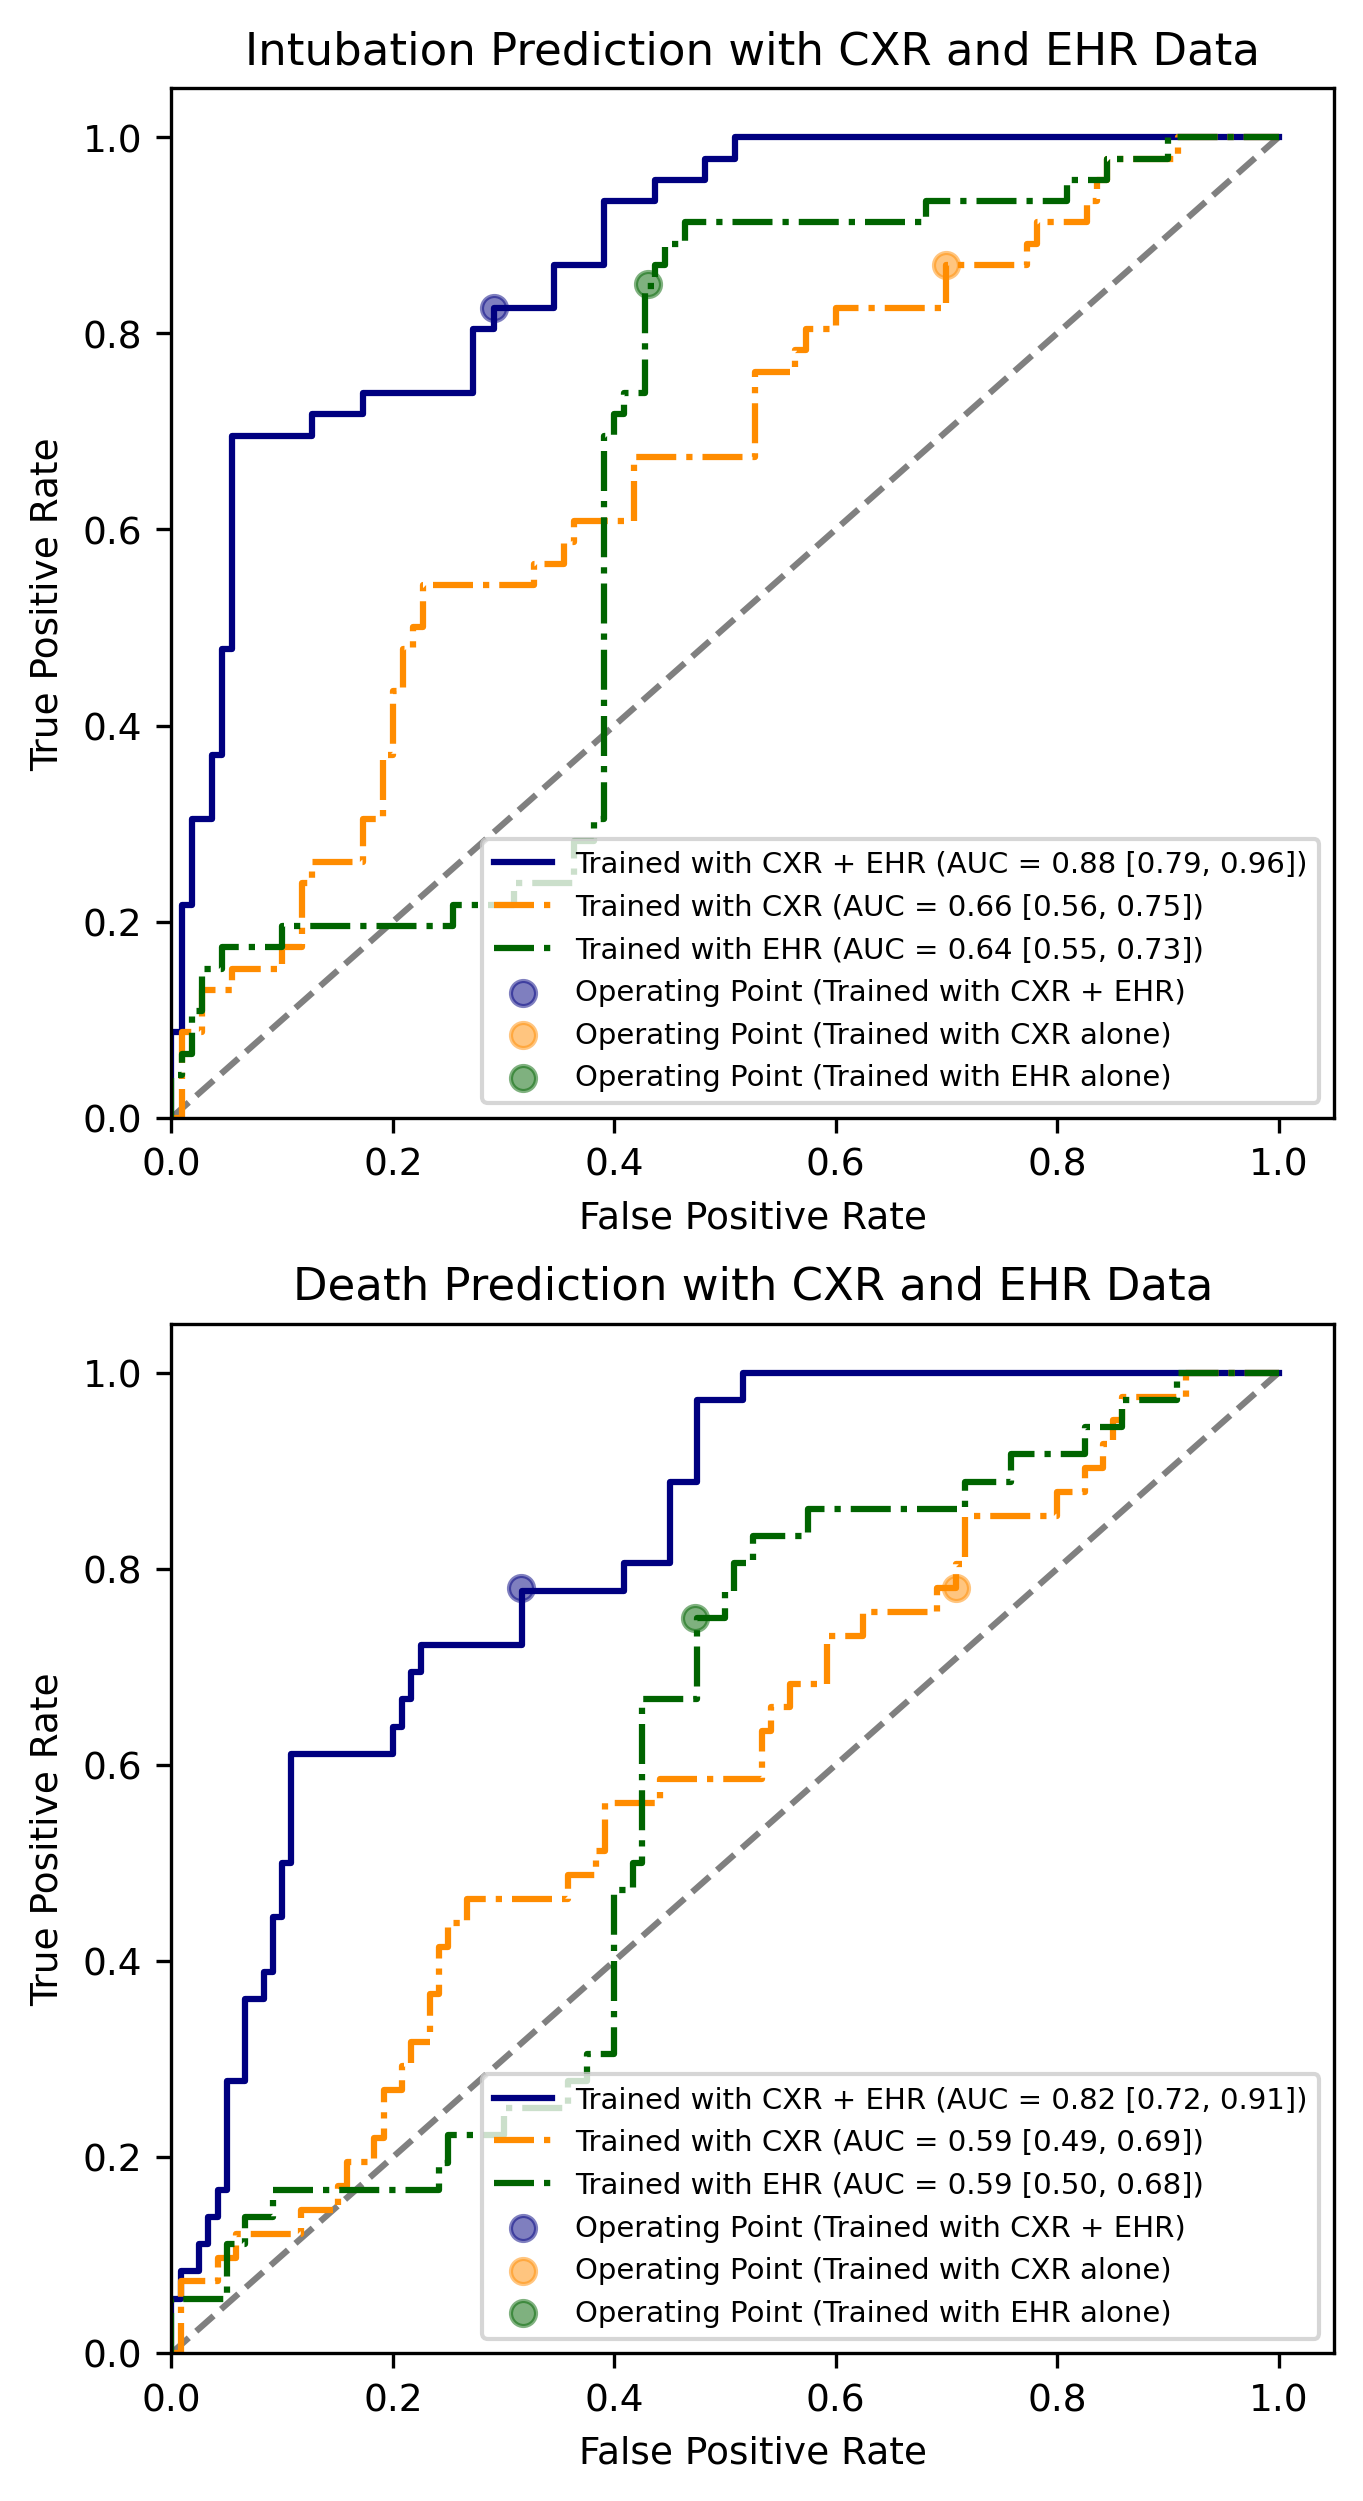

In [20]:
fontsize = 9
font = {'size': fontsize}
leg_fontsize = 7
plt.rc('font', **font)
dpi = 300
fig = plt.figure(figsize=(5, 10), dpi=dpi)
latest_epoch = 150

fontsize = 14
ax3 = fig.add_subplot(211)

fpr_scores, tpr_scores, thresholds = roc_curve(intubs_no_DNI, cxr_ehr_pred)
roc_auc_scores = auc(fpr_scores, tpr_scores)

ax3.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax3.plot(fpr_scores, tpr_scores, color='navy',
         label=f'Trained with CXR + EHR (AUC = {roc_auc_scores:.2f} [0.79, 0.96])')
ax3.scatter(0.291, 0.826, color='navy', marker='o', alpha = 0.5,
         label=f'Operating Point (Trained with CXR + EHR)')
ax3.plot(graph_intub_x, graph_intub_y, color='darkorange', linestyle='-.',
         label=f'Trained with CXR (AUC = 0.66 [0.56, 0.75])')
ax3.scatter(0.7, 0.8696, color='darkorange', marker='o', alpha = 0.5,
         label=f'Operating Point (Trained with CXR alone)')

fpr_scores, tpr_scores, thresholds = roc_curve(intubs_no_DNI, ehr_pred)
roc_auc_scores = auc(fpr_scores, tpr_scores)
ax3.plot(fpr_scores, tpr_scores, color='darkgreen', linestyle='-.',
         label=f'Trained with EHR (AUC = {roc_auc_scores:.2f} [0.55, 0.73])')
ax3.scatter(0.43, 0.85, color='darkgreen', marker='o', alpha = 0.5,
         label=f'Operating Point (Trained with EHR alone)')
ax3.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('Intubation Prediction with CXR and EHR Data')
ax3.legend(loc="lower right", fontsize = leg_fontsize)

ax4 = fig.add_subplot(212)

fpr_scores, tpr_scores, thresholds = roc_curve(deaths_no_DNI, cxr_ehr_pred)
roc_auc_scores = auc(fpr_scores, tpr_scores)

ax4.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax4.plot(fpr_scores, tpr_scores, color='navy',
         label=f'Trained with CXR + EHR (AUC = {roc_auc_scores:.2f} [0.72, 0.91])')
ax4.scatter(0.316, 0.78, color='navy', marker='o', alpha = 0.5,
         label=f'Operating Point (Trained with CXR + EHR)')
ax4.plot(graph_death_x, graph_death_y, color='darkorange', linestyle='-.',
         label=f'Trained with CXR (AUC = 0.59 [0.49, 0.69])')
ax4.scatter(0.7083, 0.7805, color='darkorange', marker='o', alpha = 0.5,
         label=f'Operating Point (Trained with CXR alone)')

fpr_scores, tpr_scores, thresholds = roc_curve(deaths_no_DNI, ehr_pred)
roc_auc_scores = auc(fpr_scores, tpr_scores)
ax4.plot(fpr_scores, tpr_scores, color='darkgreen', linestyle='-.',
         label=f'Trained with EHR (AUC = {roc_auc_scores:.2f} [0.50, 0.68])')
ax4.scatter(0.473, 0.75, color='darkgreen', marker='o', alpha = 0.5,
         label=f'Operating Point (Trained with EHR alone)')
ax4.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('Death Prediction with CXR and EHR Data')
ax4.legend(loc="lower right", fontsize = leg_fontsize)

In [21]:
#### fig = plt.figure(figsize=(10, 10), dpi=dpi)

fontsize = 16
ymin = 0
ax1 = fig.add_subplot(221)

precision_scores, recall_scores, _ = precision_recall_curve(intubs, preds_scores)
precision_admits, recall_admits, _ = precision_recall_curve(intubs, preds_admits)

ax1.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax1.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax1.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax1.set_xlabel('Recall (Sensitivity with regards to Intubation)')
ax1.set_ylabel('Precision (PPV with regards to Intubation)')
ax1.set_title('Intubated')
ax1.legend(loc="lower right", fontsize=leg_fontsize)
fig.show()

ax2 = fig.add_subplot(222)

precision_scores, recall_scores, _ = precision_recall_curve(intubs, preds_scores, pos_label=0)
precision_admits, recall_admits, _ = precision_recall_curve(intubs, preds_admits, pos_label=0)

ax2.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax2.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax2.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax2.set_xlabel('Recall (Specificity with regards to Intubation)')
ax2.set_ylabel('Precision (NPV with regards to Intubation)')
ax2.set_title('Not Intubated')
ax2.legend(loc="lower right", fontsize=leg_fontsize)

ax3 = fig.add_subplot(223)

precision_scores, recall_scores, _ = precision_recall_curve(deaths, preds_scores)
precision_admits, recall_admits, _ = precision_recall_curve(deaths, preds_admits)

ax3.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax3.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax3.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax3.set_xlabel('Recall (Sensitivity with regards to Death)')
ax3.set_ylabel('Precision (PPV with regards to Death)')
ax3.set_title('Death')
ax3.legend(loc="upper right", fontsize=leg_fontsize)
fig.show()

ax4 = fig.add_subplot(224)

precision_scores, recall_scores, _ = precision_recall_curve(deaths, preds_scores, pos_label=0)
precision_admits, recall_admits, _ = precision_recall_curve(deaths, preds_admits, pos_label=0)

ax4.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax4.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax4.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax4.set_xlabel('Recall (Specificity with regards to Death)')
ax4.set_ylabel('Precision (NPV with regards to Death)')
ax4.set_title('Survival')
ax4.legend(loc="lower right", fontsize=leg_fontsize)
fig.show()

fig.savefig('Supplemental Figure E2.tif')


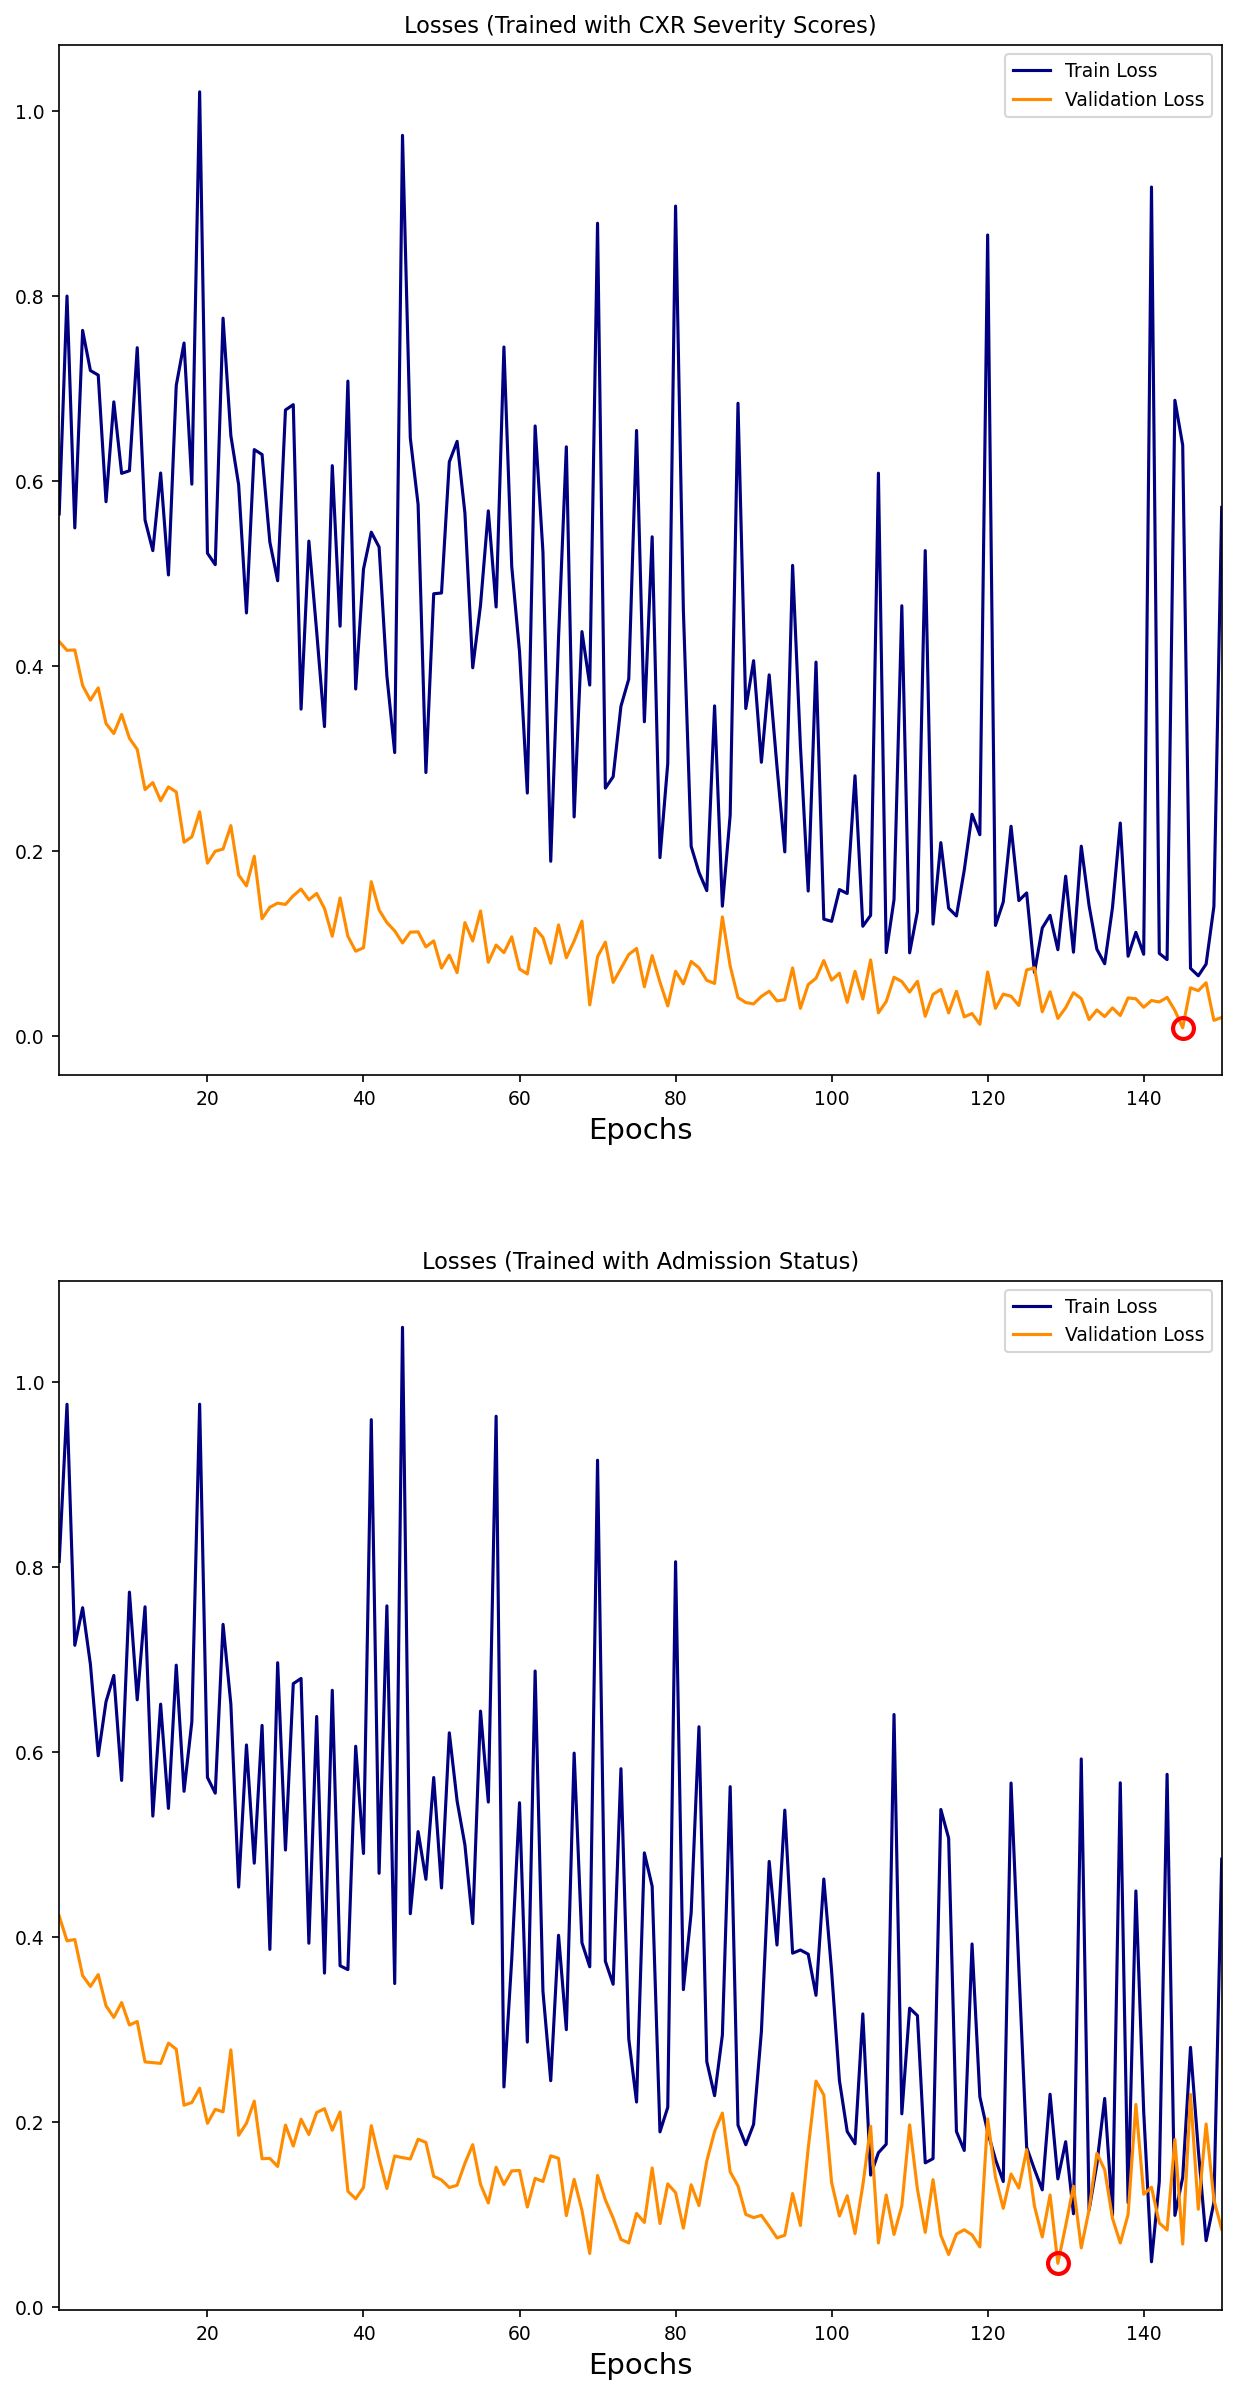

In [22]:
epochs = range(1, 150 + 1)
losses_scores = torch.load("/home/aisinai/work/covid19/densenet121/20200507/score3/losses.pt")
losses_scores = losses_scores[:,0:150]
losses_admits = torch.load("/home/aisinai/work/covid19/densenet121/20200507/admit3/losses.pt")
losses_admits = losses_admits[:,0:150]


fig = plt.figure(figsize=(10, 20), dpi=dpi/2)
latest_epoch = 150

fontsize = 14
ax1 = fig.add_subplot(211)
ax1.plot(epochs, losses_scores[0, :], '-', color='navy')
ax1.plot(epochs, losses_scores[1, :], '-', color='darkorange')
ax1.plot(145, losses_scores[1, 144], 'o', color='red', markerfacecolor='None', markersize=10, markeredgewidth=2)
ax1.set_title('Losses (Trained with CXR Severity Scores)')
ax1.set_xlabel('Epochs', fontsize=fontsize)
ax1.axis(xmin=1, xmax=latest_epoch)
ax1.legend(["Train Loss", "Validation Loss"], loc="upper right")

ax2 = fig.add_subplot(212)
ax2.plot(epochs, losses_admits[0, :], '-', color='navy')
ax2.plot(epochs, losses_admits[1, :], '-', color='darkorange')
ax2.plot(129, losses_admits[1, 128], 'o', color='red', markerfacecolor='None', markersize=10, markeredgewidth=2)
ax2.set_title('Losses (Trained with Admission Status)')
ax2.set_xlabel('Epochs', fontsize=fontsize)
ax2.axis(xmin=1, xmax=latest_epoch)
ax2.legend(["Train Loss", "Validation Loss"], loc="upper right")

fig.show()

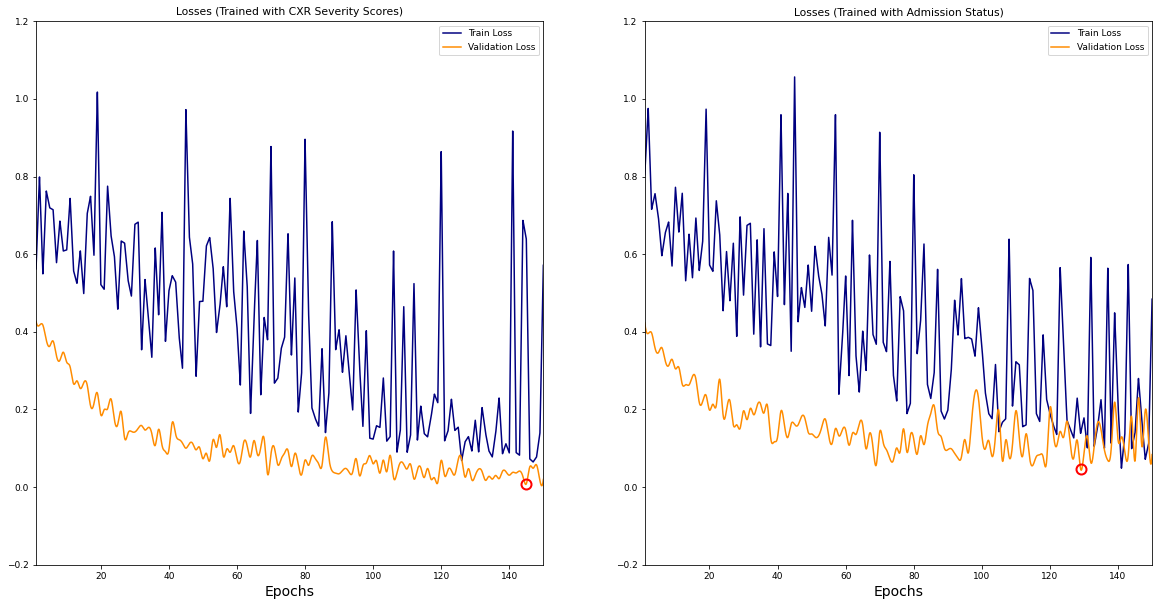

In [23]:
epochs = range(1, 150 + 1)
losses_scores = torch.load("/home/aisinai/work/covid19/densenet121/20200507/score3/losses.pt")
losses_scores = losses_scores[:,0:150]
losses_admits = torch.load("/home/aisinai/work/covid19/densenet121/20200507/admit3/losses.pt")
losses_admits = losses_admits[:,0:150]

epochs_new = np.linspace(0, 150, 10000)  

k_train=1
k_valid=3
spl_losses_scores_train = make_interp_spline(epochs, losses_scores[0, :], k=k_train)
losses_scores_train = spl_losses_scores_train(epochs_new)
spl_losses_scores_valid = make_interp_spline(epochs, losses_scores[1, :], k=k_valid)
losses_scores_valid = spl_losses_scores_valid(epochs_new)

spl_losses_admits_train = make_interp_spline(epochs, losses_admits[0, :], k=k_train)
losses_admits_train = spl_losses_admits_train(epochs_new)
spl_losses_admits_valid = make_interp_spline(epochs, losses_admits[1, :], k=k_valid)
losses_admits_valid = spl_losses_admits_valid(epochs_new)

fig = plt.figure(figsize=(20, 10))
latest_epoch = 150

fontsize = 14
ax1 = fig.add_subplot(121)
ax1.plot(epochs_new, losses_scores_train, '-', color='navy')
ax1.plot(epochs_new, losses_scores_valid, '-', color='darkorange')
ax1.plot(145, losses_scores[1, 144], 'o', color='red', markerfacecolor='None', markersize=10, markeredgewidth=2)
ax1.set_title('Losses (Trained with CXR Severity Scores)')
ax1.set_xlabel('Epochs', fontsize=fontsize)
ax1.axis(xmin=1, xmax=latest_epoch, ymin=-0.2, ymax=1.2)
ax1.legend(["Train Loss", "Validation Loss"], loc="upper right")

ax2 = fig.add_subplot(122)
ax2.plot(epochs_new, losses_admits_train, '-', color='navy')
ax2.plot(epochs_new, losses_admits_valid, '-', color='darkorange')
ax2.plot(129, losses_admits[1, 128], 'o', color='red', markerfacecolor='None', markersize=10, markeredgewidth=2)
ax2.set_title('Losses (Trained with Admission Status)')
ax2.set_xlabel('Epochs', fontsize=fontsize)
ax2.axis(xmin=1, xmax=latest_epoch, ymin=-0.2, ymax=1.2)
ax2.legend(["Train Loss", "Validation Loss"], loc="upper right")

fig.show()

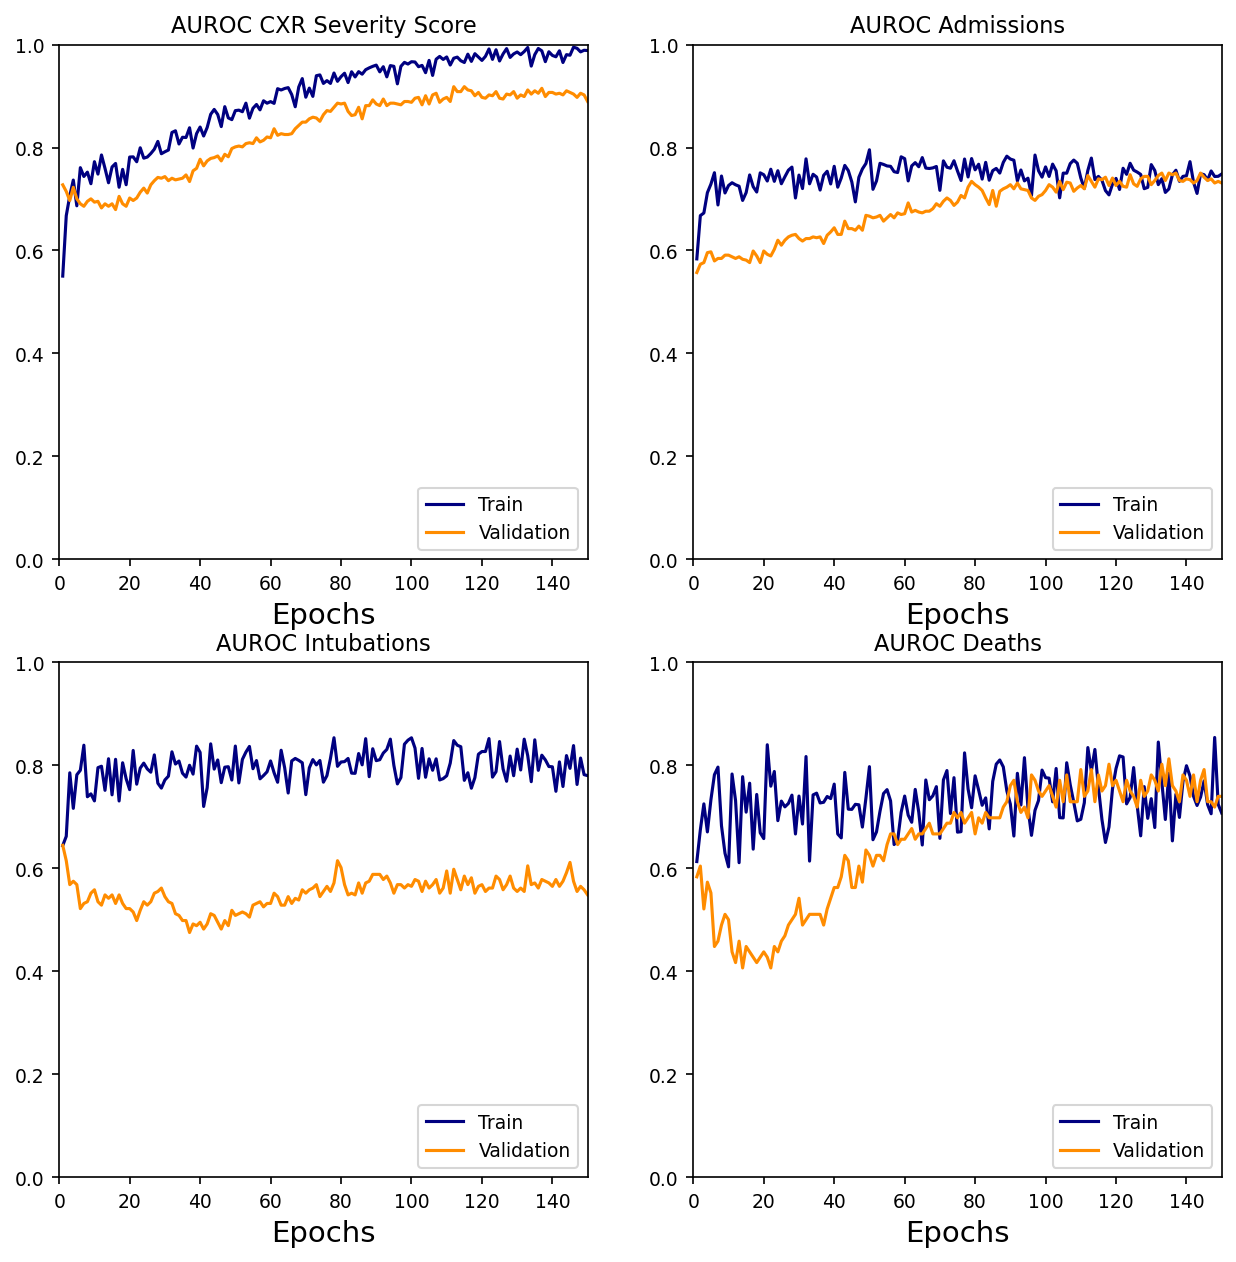

In [24]:
font = {'size': 9}
plt.rc('font', **font)

epochs = range(1, 150 + 1)
aurocs = torch.load("/home/aisinai/work/covid19/densenet121/20200507/score3/aurocs.pt")
aurocs = aurocs[:,0:150]

fig = plt.figure(figsize=(10, 10), dpi=dpi/2)
latest_epoch = 150

ymin = 0
ax1 = fig.add_subplot(221)
ax1.plot(epochs, aurocs[0, :, 0], '-', color='navy')
ax1.plot(epochs, aurocs[1, :, 0], '-', color='darkorange')
ax1.legend(["Train", "Validation"], loc="lower right")
ax1.set_title('AUROC CXR Severity Score')
ax1.set_xlabel('Epochs', fontsize=fontsize)
ax1.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

ax2 = fig.add_subplot(222)
ax2.plot(epochs, aurocs[0, :, 1], '-', color='navy')
ax2.plot(epochs, aurocs[1, :, 1], '-', color='darkorange')
ax2.legend(["Train", "Validation"], loc="lower right")
ax2.set_title('AUROC Admissions')
ax2.set_xlabel('Epochs', fontsize=fontsize)
ax2.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

ax3 = fig.add_subplot(223)
ax3.plot(epochs, aurocs[0, :, 2], '-', color='navy')
ax3.plot(epochs, aurocs[1, :, 2], '-', color='darkorange')
ax3.legend(["Train", "Validation"], loc="lower right")
ax3.set_title('AUROC Intubations')
ax3.set_xlabel('Epochs', fontsize=fontsize)
ax3.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

ax4 = fig.add_subplot(224)
ax4.plot(epochs, aurocs[0, :, 3], '-', color='navy')
ax4.plot(epochs, aurocs[1, :, 3], '-', color='darkorange')
ax4.legend(["Train", "Validation"], loc="lower right")
ax4.set_title('AUROC Deaths')
ax4.set_xlabel('Epochs', fontsize=fontsize)
ax4.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

plt.show()

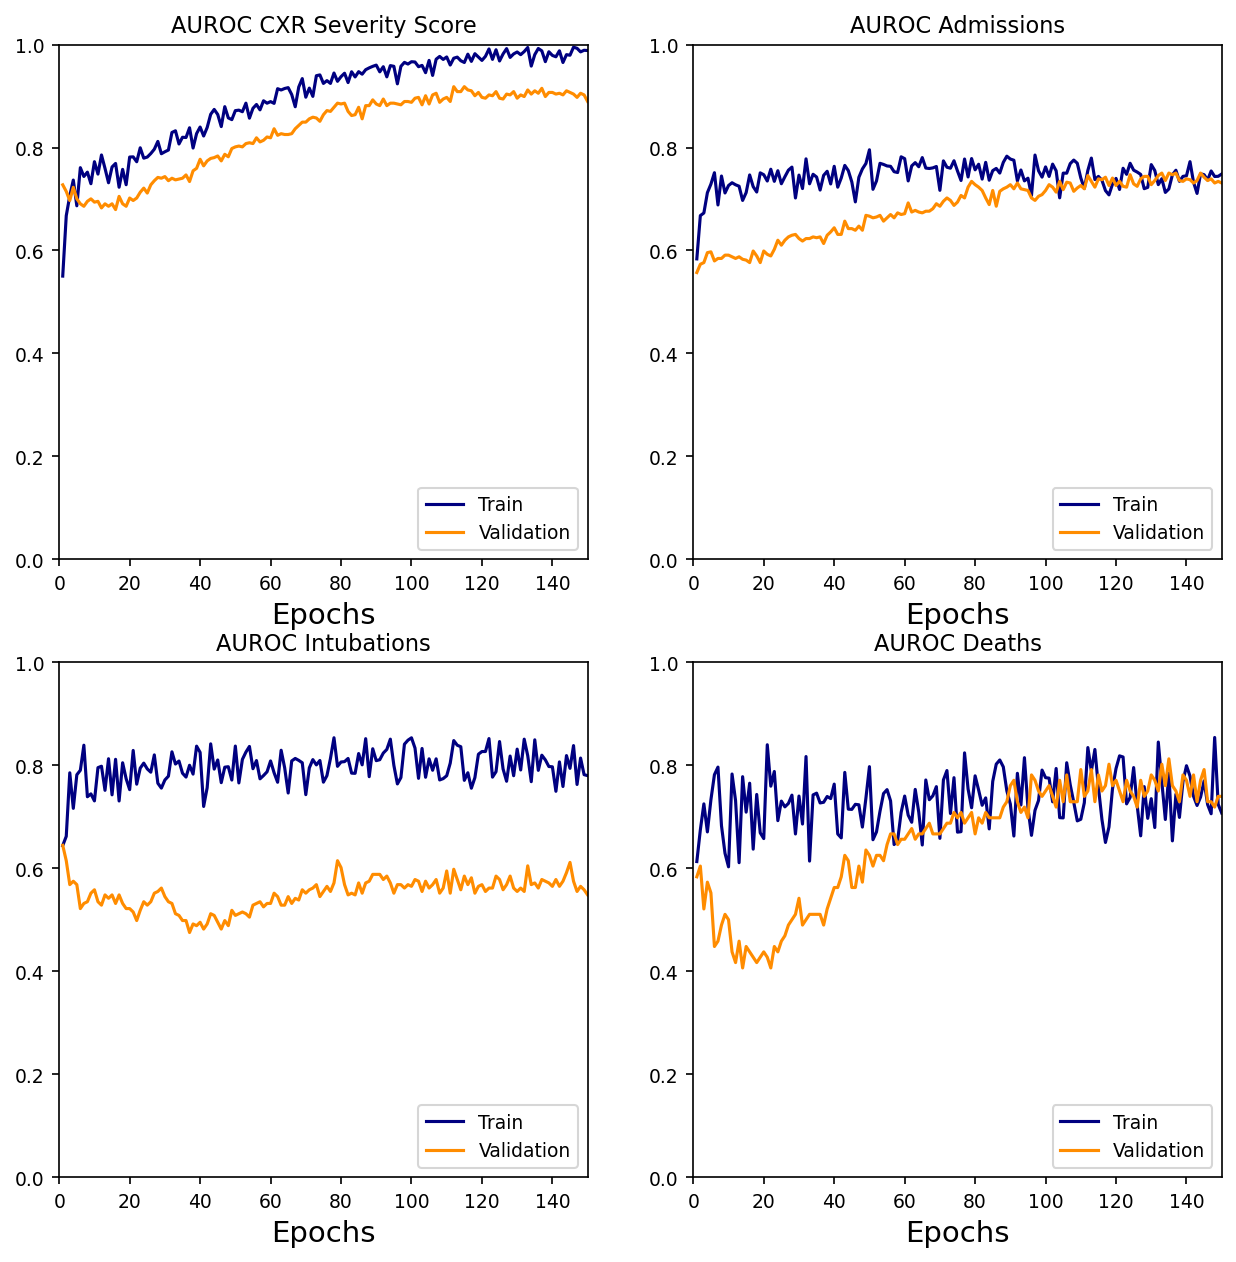

In [25]:
epochs = range(1, 150 + 1)
losses = torch.load("/home/aisinai/work/covid19/densenet121/20200507/admit3/losses.pt")
aurocs = aurocs[:,0:150]

fig = plt.figure(figsize=(10, 10), dpi=dpi/2)
latest_epoch = 150

ax1 = fig.add_subplot(221)
ax1.plot(epochs, aurocs[0, :, 0], '-', color='navy')
ax1.plot(epochs, aurocs[1, :, 0], '-', color='darkorange')
ax1.legend(["Train", "Validation"], loc="lower right")
ax1.set_title('AUROC CXR Severity Score')
ax1.set_xlabel('Epochs', fontsize=fontsize)
ax1.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

ax2 = fig.add_subplot(222)
ax2.plot(epochs, aurocs[0, :, 1], '-', color='navy')
ax2.plot(epochs, aurocs[1, :, 1], '-', color='darkorange')
ax2.legend(["Train", "Validation"], loc="lower right")
ax2.set_title('AUROC Admissions')
ax2.set_xlabel('Epochs', fontsize=fontsize)
ax2.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

ax3 = fig.add_subplot(223)
ax3.plot(epochs, aurocs[0, :, 2], '-', color='navy')
ax3.plot(epochs, aurocs[1, :, 2], '-', color='darkorange')
ax3.legend(["Train", "Validation"], loc="lower right")
ax3.set_title('AUROC Intubations')
ax3.set_xlabel('Epochs', fontsize=fontsize)
ax3.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

ax4 = fig.add_subplot(224)
ax4.plot(epochs, aurocs[0, :, 3], '-', color='navy')
ax4.plot(epochs, aurocs[1, :, 3], '-', color='darkorange')
ax4.legend(["Train", "Validation"], loc="lower right")
ax4.set_title('AUROC Deaths')
ax4.set_xlabel('Epochs', fontsize=fontsize)
ax4.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

plt.show()

## Calculate Accuracy Confidence Intervals

## Bootstrap to calculate CI

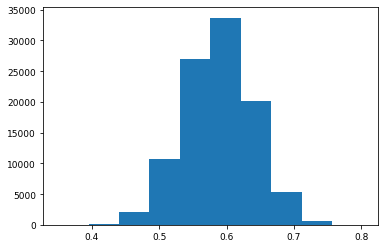

95% confidence interval 0.4874 and 0.6873


In [7]:
# Bootstrap to calculate CI
import numpy as np
from matplotlib import pyplot

# select classification category
category = deaths
is_score = True

# configure bootstrap
n_iterations = 100000
n_resample = len(category)
values = np.array(category).flatten()
if is_score:
    predictions = np.array(preds_scores).flatten()
else:
    predictions = np.array(preds_admits).flatten()

# run bootstrap
stats = list()
for i in range(n_iterations):
    # evaluate model
    idx = np.random.choice(np.arange(len(values)), n_resample)
    values_sample = values[idx]
    predictions_sample = predictions[idx]
    fpr, tpr, _ = roc_curve(values_sample, predictions_sample)
    roc_auc = auc(fpr, tpr)
    stats.append(roc_auc)
    
# plot scores
pyplot.hist(stats)
pyplot.show()
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.0f%% confidence interval %.4f and %.4f' % (alpha*100, lower, upper))

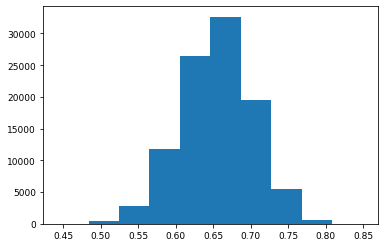

95% confidence interval 0.5590 and 0.7461


In [8]:
# Bootstrap to calculate CI for intubations without DNI patients
from sklearn.metrics import accuracy_score

# select classification category
category = intubs_no_DNI
is_score = True

# configure bootstrap
n_iterations = 100000
n_resample = len(category)
values = np.array(category).flatten()
if is_score:
    predictions = np.array(preds_scores_no_DNI).flatten()
else:
    predictions = np.array(preds_admits_no_DNI).flatten()

# run bootstrap
stats = list()
for i in range(n_iterations):
    # evaluate model
    idx = np.random.choice(np.arange(len(values)), n_resample)
    values_sample = values[idx]
    predictions_sample = predictions[idx]
    fpr, tpr, _ = roc_curve(values_sample, predictions_sample)
    roc_auc = auc(fpr, tpr)
    stats.append(roc_auc)

# plot scores
pyplot.hist(stats)
pyplot.show()
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.0f%% confidence interval %.4f and %.4f' % (alpha*100, lower, upper))

accuracy:0.40, precision:0.3, recall:0.74, F1_score:0.43


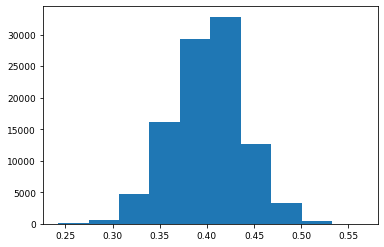

95% confidence interval: [0.32, 0.48]


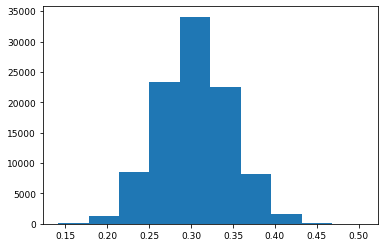

95% confidence interval: [0.22, 0.39]


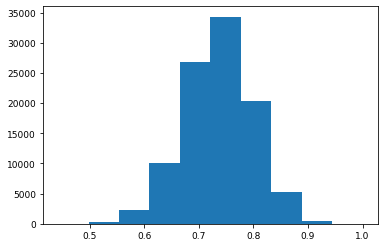

95% confidence interval: [0.61, 0.85]


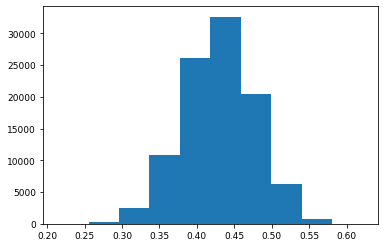

95% confidence interval: [0.33, 0.52]


In [9]:
# Bootstrap to calculate accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# configure bootstrap
category = deaths
is_score = True
age = "old"
n_iterations = 100000
cutoff = 0.8501

# assign appropriate patients per age group
values = np.where(np.array(category) == 1, 1, 0).flatten()
if is_score:
    predictions = np.where(np.array(preds_scores) > cutoff, 1, 0).flatten()
else:
    predictions = np.where(np.array(preds_admits) > cutoff, 1, 0).flatten()

if age == "young":
    values = values[:51]
    predictions = predictions[:51]
elif age == "old":
    values = values[51:]
    predictions = predictions[51:]
else:
    values = values
    predictions = predictions
    
n_resample = len(category)
accuracy = accuracy_score(values, predictions)
precision = precision_score(values, predictions)
recall = recall_score(values, predictions)
F1_score = f1_score(values, predictions)
print(f'accuracy:{accuracy:.2f}, precision:{precision:.2g}, recall:{recall:.2f}, F1_score:{F1_score:.2f}')

# run bootstrap
accuracies = list()
precisions = list()
recalls    = list()
f1_scores  = list()
for i in range(n_iterations):
    # evaluate model
    idx = np.random.choice(np.arange(len(values)), n_resample)
    values_sample = values[idx]
    predictions_sample = predictions[idx]
    accuracies.append(accuracy_score(values_sample, predictions_sample))
    precisions.append(precision_score(values_sample, predictions_sample))
    recalls.append(recall_score(values_sample, predictions_sample))
    f1_scores.append(f1_score(values_sample, predictions_sample))

# confidence intervals
def calculate_CI(stats, values, predictions):
    pyplot.hist(stats)
    pyplot.show()
    
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    print('%.0f%% confidence interval: [%.2f, %.2f]' % (alpha*100, lower, upper))
    return lower, upper

for stat in [accuracies, precisions, recalls, f1_scores]:
    calculate_CI(stat, values, predictions)

accuracy:0.49, precision:0.38, recall:0.78, F1_score:0.51


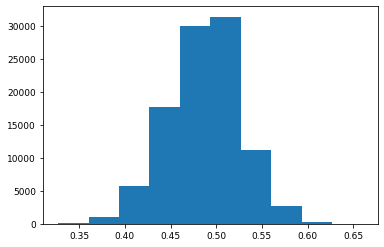

95% confidence interval: [0.41, 0.56]


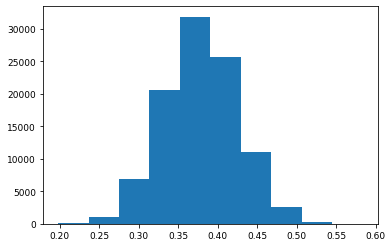

95% confidence interval: [0.29, 0.47]


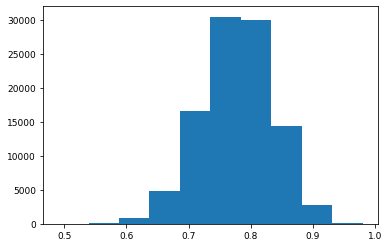

95% confidence interval: [0.66, 0.88]


KeyboardInterrupt: 

In [18]:
# Bootstrap to calculate accuracy for intubations without DNI patients
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# configure bootstrap
category = intubs_no_DNI
is_score = False
age = "old"
n_iterations = 100000
cutoff = 0.45

# assign appropriate patients per age group
values = np.where(np.array(category) == 1, 1, 0).flatten()
if is_score:
    predictions = np.where(np.array(preds_scores_no_DNI) > cutoff, 1, 0).flatten()
else:
    predictions = np.where(np.array(preds_admits_no_DNI) > cutoff, 1, 0).flatten()

if age == "young":
    values = values[:51]
    predictions = predictions[:51]
elif age == "old":
    values = values[51:]
    predictions = predictions[51:]
else:
    values = values
    predictions = predictions
    
n_resample = len(category)
accuracy = accuracy_score(values, predictions)
precision = precision_score(values, predictions)
recall = recall_score(values, predictions)
F1_score = f1_score(values, predictions)
print(f'accuracy:{accuracy:.2f}, precision:{precision:.2g}, recall:{recall:.2f}, F1_score:{F1_score:.2f}')

# run bootstrap
accuracies = list()
precisions = list()
recalls    = list()
f1_scores  = list()
for i in range(n_iterations):
    # evaluate model
    idx = np.random.choice(np.arange(len(values)), n_resample)
    values_sample = values[idx]
    predictions_sample = predictions[idx]
    accuracies.append(accuracy_score(values_sample, predictions_sample))
    precisions.append(precision_score(values_sample, predictions_sample))
    recalls.append(recall_score(values_sample, predictions_sample))
    f1_scores.append(f1_score(values_sample, predictions_sample))

# confidence intervals
def calculate_CI(stats, values, predictions):
    pyplot.hist(stats)
    pyplot.show()
    
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    print('%.0f%% confidence interval: [%.2f, %.2f]' % (alpha*100, lower, upper))
    return lower, upper

for stat in [accuracies, precisions, recalls, f1_scores]:
    calculate_CI(stat, values, predictions)